In [201]:
import air_quality_functions as aqf

import pandas as pd
import numpy as np

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import r2_score, mean_squared_error 

RSEED = 42

In [202]:
df = pd.read_csv("./data/Train.csv") #for test data no target defined, we treat the "train" data as the whole dataset

In [203]:
df.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


In [204]:
features = ["temp", "precip", "rel_humidity", "wind_dir", "wind_spd", "atmos_press"]
df = aqf.convert_str_to_list(df, features)

In [205]:
#train-test split
y = df.target
X = df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### Adding metadata about the sensor locations

In [206]:
# read .csv file
metadata = pd.read_csv("./data/airqo_metadata.csv")

In [207]:
# calculate fireplaces per km2 for each location
metadata['fires_per_km2'] = (metadata.hh_cook_charcoal + metadata.hh_cook_firewood + metadata.hh_burn_waste) / metadata.km2

In [208]:
# calculate atmospheric standard pressure for each location

alts = metadata.loc_altitude
# atmospheric pressure equation (in dependence of altitude) (see also: https://en.wikipedia.org/wiki/Atmospheric_pressure)
p0 = 101325.0       # Pa        Sea level standard atmospheric pressure
g  = 9.80665        # m/s^2     Earth-surface gravitational acceleration
M  = 0.02896968     # kg/mol    Molar mass of dry air
R0 = 8.314462618    # J/(mol·K) Universal gas constant
T0 = 288.16         # K         Sea level standard temperature
h  = alts           # m         Height above Earth-surface
pressure = p0 * np.exp( -(g * h * M) / (T0 * R0))

# add new column to metadata df
metadata['std_pressure'] = pressure / 1000

In [209]:
metadata[['location', 'fires_per_km2', 'std_pressure']]

,location,fires_per_km2,std_pressure
0,A,364.736842,88.698552
1,B,277.592593,88.352152
2,C,3753.176471,88.112567
3,D,946.250000,90.200405
4,E,658.750000,88.026935


In [210]:
# add new columns with std_pressure and fires_per_km2 to dataframes
X_train = X_train.join(metadata[['location', 'fires_per_km2', 'std_pressure']].set_index('location'), on='location')
X_test = X_test.join(metadata[['location', 'fires_per_km2', 'std_pressure']].set_index('location'), on='location')

In [211]:
#impute missing values
X_train = aqf.impute_values(X_train,features,strategy='nearest')
X_test = aqf.impute_values(X_test,features,strategy='nearest')

In [212]:
max_num_of_nans = 50

#drop rows with too many nans
for feature in features:
    y_train.drop(X_train[X_train[feature + '_nans'] > max_num_of_nans].index, inplace = True)
    X_train.drop(X_train[X_train[feature + '_nans'] > max_num_of_nans].index, inplace = True)

In [213]:
#drop number_of_non_columns
for feature in features:
    X_train.drop(feature + '_nans',axis=1,inplace=True)
    X_test.drop(feature + '_nans',axis=1,inplace=True)

In [214]:
#add columns with min, max etc
for feature in features:
    X_train = aqf.aggregate_features(X_train,feature)
    X_test = aqf.aggregate_features(X_test,feature)

In [215]:
blocksize = 6

X_train = aqf.time_blocks(X_train, features, blocksize)
X_test = aqf.time_blocks(X_test, features, blocksize)

In [217]:
# correct atmospheric pressure by standard pressure for that altitude
def correct_pressure(data):
    for feature in data.columns:
        if ('atmos_press' in feature) and ('std' not in feature) and ('var' not in feature) and ('ptp' not in feature):
            data[feature] = data[feature] - data['std_pressure']
    return data.drop('std_pressure', axis=1)

In [218]:
X_train = correct_pressure(X_train)
X_test = correct_pressure(X_test)

X_train.head(20)

,ID,location,fires_per_km2,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,...,atmos_press_10,atmos_press_11,atmos_press_12,atmos_press_13,atmos_press_14,atmos_press_15,atmos_press_16,atmos_press_17,atmos_press_18,atmos_press_19
0,ID_train_9860,E,658.750000,29.616667,19.333333,24.616116,2.946577,8.682316,24.350000,10.283333,...,0.365009,0.359593,0.138898,0.299871,0.408621,0.440287,0.191259,0.344732,0.423482,0.380843
1,ID_train_13432,D,946.250000,29.608333,17.033333,22.535950,3.201176,10.247525,21.933333,12.575000,...,0.197929,0.338623,0.201262,0.255151,0.286123,0.391262,0.061540,0.154734,0.228623,0.425012
2,ID_train_6910,A,364.736842,27.275000,16.658333,20.292531,2.686268,7.216038,20.083333,10.616667,...,-0.121746,-0.342857,-0.264802,-0.235635,-0.236885,-0.177668,-0.165825,-0.173931,-0.062857,-0.274107
3,ID_train_847,C,3753.176471,27.300000,17.275000,20.755785,2.056465,4.229047,20.058333,10.025000,...,-0.464512,-0.324095,-0.309512,-0.292428,-0.612984,-0.393123,-0.405206,-0.295623,-0.552428,-0.383539
4,ID_train_2357,A,364.736842,32.650000,19.400000,24.861251,3.511626,12.331518,24.133333,13.250000,...,-0.443552,-0.347857,-0.404941,-0.270357,-0.603413,-0.451885,-0.387302,-0.264663,-0.590635,-0.302857
5,ID_train_14878,D,946.250000,34.925000,17.075000,24.612672,5.436987,29.560825,23.558333,17.850000,...,0.091818,0.348345,0.464734,0.318206,0.094040,0.359040,0.441818,0.352651,0.111818,0.368623
6,ID_train_11288,E,658.750000,29.475000,18.825000,23.240872,3.179039,10.106286,22.708333,10.650000,...,0.534315,0.489871,0.530843,0.581398,0.336954,0.215982,0.315982,0.477232,0.343065,0.249037
7,ID_train_9982,D,946.250000,31.125000,14.650000,24.193526,4.335305,18.794867,23.925000,16.475000,...,0.330290,0.355568,0.546540,0.200706,0.365290,0.347929,0.512651,0.163901,0.380429,0.377651
8,ID_train_1008,B,277.592593,27.150000,19.790909,23.179408,2.152859,4.634803,22.891667,7.359091,...,0.312103,0.020259,0.111585,0.144237,0.363227,0.158037,0.129515,0.115727,0.289110,0.052823
9,ID_train_7452,D,946.250000,29.608333,19.166667,23.189187,2.824802,7.979507,22.333333,10.441667,...,0.307373,0.447373,0.080706,0.203901,0.260984,0.403762,0.046123,0.180568,0.197929,0.338623


In [219]:
def agg_diffs(data, features, blocksize):
    for feature in features:
        for i in range(int(121/blocksize) -1):
            data[feature + '_' + str(i) + 'to' + str(i+1)] = data[feature + '_' + str(i+1)] - data[feature + '_' + str(i)]
    return data

In [220]:
X_train = agg_diffs(X_train, features, blocksize)
X_test = agg_diffs(X_test, features, blocksize)

In [221]:
X_train.columns

Index(['ID', 'location', 'fires_per_km2', 'max_temp', 'min_temp', 'mean_temp',
       'std_temp', 'var_temp', 'median_temp', 'ptp_temp',
       ...
       'atmos_press_9to10', 'atmos_press_10to11', 'atmos_press_11to12',
       'atmos_press_12to13', 'atmos_press_13to14', 'atmos_press_14to15',
       'atmos_press_15to16', 'atmos_press_16to17', 'atmos_press_17to18',
       'atmos_press_18to19'],
      dtype='object', length=279)

In [222]:
# drop ID column and also min/median precipitations (they are always 0 for this dataset)
X_train.drop(['ID', 'min_precip', 'median_precip'],axis=1,inplace=True)
X_test.drop(['ID', 'min_precip', 'median_precip'],axis=1,inplace=True)

### One hot encoding

In [223]:
X_train.head(20)

,location,fires_per_km2,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,max_precip,...,atmos_press_9to10,atmos_press_10to11,atmos_press_11to12,atmos_press_12to13,atmos_press_13to14,atmos_press_14to15,atmos_press_15to16,atmos_press_16to17,atmos_press_17to18,atmos_press_18to19
0,E,658.750000,29.616667,19.333333,24.616116,2.946577,8.682316,24.350000,10.283333,0.017,...,0.025139,-0.005417,-0.220694,0.160972,0.108750,0.031667,-0.249028,0.153472,0.078750,-0.042639
1,D,946.250000,29.608333,17.033333,22.535950,3.201176,10.247525,21.933333,12.575000,2.229,...,0.017361,0.140694,-0.137361,0.053889,0.030972,0.105139,-0.329722,0.093194,0.073889,0.196389
2,A,364.736842,27.275000,16.658333,20.292531,2.686268,7.216038,20.083333,10.616667,10.977,...,0.091755,-0.221111,0.078056,0.029167,-0.001250,0.059217,0.011843,-0.008106,0.111073,-0.211250
3,C,3753.176471,27.300000,17.275000,20.755785,2.056465,4.229047,20.058333,10.025000,28.765,...,-0.240556,0.140417,0.014583,0.017083,-0.320556,0.219861,-0.012083,0.109583,-0.256806,0.168889
4,A,364.736842,32.650000,19.400000,24.861251,3.511626,12.331518,24.133333,13.250000,10.609,...,-0.352361,0.095694,-0.057083,0.134583,-0.333056,0.151528,0.064583,0.122639,-0.325972,0.287778
5,D,946.250000,34.925000,17.075000,24.612672,5.436987,29.560825,23.558333,17.850000,0.017,...,-0.256528,0.256528,0.116389,-0.146528,-0.224167,0.265000,0.082778,-0.089167,-0.240833,0.256806
6,E,658.750000,29.475000,18.825000,23.240872,3.179039,10.106286,22.708333,10.650000,5.119,...,-0.218750,-0.044444,0.040972,0.050556,-0.244444,-0.120972,0.100000,0.161250,-0.134167,-0.094028
7,D,946.250000,31.125000,14.650000,24.193526,4.335305,18.794867,23.925000,16.475000,8.828,...,0.157917,0.025278,0.190972,-0.345833,0.164583,-0.017361,0.164722,-0.348750,0.216528,-0.002778
8,B,277.592593,27.150000,19.790909,23.179408,2.152859,4.634803,22.891667,7.359091,0.000,...,0.149293,-0.291843,0.091326,0.032652,0.218990,-0.205189,-0.028523,-0.013788,0.173384,-0.236288
9,D,946.250000,29.608333,19.166667,23.189187,2.824802,7.979507,22.333333,10.441667,0.051,...,-0.003889,0.140000,-0.366667,0.123194,0.057083,0.142778,-0.357639,0.134444,0.017361,0.140694


In [224]:
X_train = pd.get_dummies(X_train, columns=['location'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['location'], drop_first=True)

In [225]:
X_train.head(20)

,fires_per_km2,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,max_precip,mean_precip,...,atmos_press_13to14,atmos_press_14to15,atmos_press_15to16,atmos_press_16to17,atmos_press_17to18,atmos_press_18to19,location_B,location_C,location_D,location_E
0,658.750000,29.616667,19.333333,24.616116,2.946577,8.682316,24.350000,10.283333,0.017,0.000140,...,0.108750,0.031667,-0.249028,0.153472,0.078750,-0.042639,0,0,0,1
1,946.250000,29.608333,17.033333,22.535950,3.201176,10.247525,21.933333,12.575000,2.229,0.021934,...,0.030972,0.105139,-0.329722,0.093194,0.073889,0.196389,0,0,1,0
2,364.736842,27.275000,16.658333,20.292531,2.686268,7.216038,20.083333,10.616667,10.977,0.200496,...,-0.001250,0.059217,0.011843,-0.008106,0.111073,-0.211250,0,0,0,0
3,3753.176471,27.300000,17.275000,20.755785,2.056465,4.229047,20.058333,10.025000,28.765,0.764091,...,-0.320556,0.219861,-0.012083,0.109583,-0.256806,0.168889,0,1,0,0
4,364.736842,32.650000,19.400000,24.861251,3.511626,12.331518,24.133333,13.250000,10.609,0.157661,...,-0.333056,0.151528,0.064583,0.122639,-0.325972,0.287778,0,0,0,0
5,946.250000,34.925000,17.075000,24.612672,5.436987,29.560825,23.558333,17.850000,0.017,0.000140,...,-0.224167,0.265000,0.082778,-0.089167,-0.240833,0.256806,0,0,1,0
6,658.750000,29.475000,18.825000,23.240872,3.179039,10.106286,22.708333,10.650000,5.119,0.137331,...,-0.244444,-0.120972,0.100000,0.161250,-0.134167,-0.094028,0,0,0,1
7,946.250000,31.125000,14.650000,24.193526,4.335305,18.794867,23.925000,16.475000,8.828,0.081950,...,0.164583,-0.017361,0.164722,-0.348750,0.216528,-0.002778,0,0,1,0
8,277.592593,27.150000,19.790909,23.179408,2.152859,4.634803,22.891667,7.359091,0.000,0.000000,...,0.218990,-0.205189,-0.028523,-0.013788,0.173384,-0.236288,1,0,0,0
9,946.250000,29.608333,19.166667,23.189187,2.824802,7.979507,22.333333,10.441667,0.051,0.001405,...,0.057083,0.142778,-0.357639,0.134444,0.017361,0.140694,0,0,1,0


## Make Baseline Model

In [226]:
#define feature
baseline_features = ['mean_wind_spd']

In [227]:
#make linear regression with mean of the 6 features
# Instantiate our model 
lin_reg = LinearRegression()

# Train the model using our data
lin_reg.fit(X_train[baseline_features], y_train)

LinearRegression()

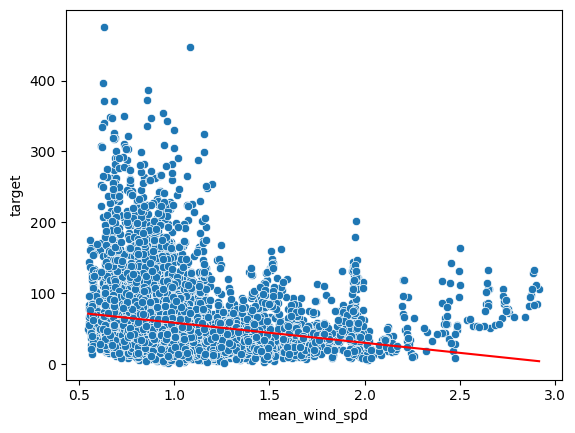

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot datapoints for mean wind speed and the baseline model

b0 = lin_reg.intercept_
b1 = lin_reg.coef_[0]
line_x = np.linspace(X_train.mean_wind_spd.min(), X_train.mean_wind_spd.max(), 200)
line_y = (line_x * b1) + b0

sns.scatterplot(x=X_train['mean_wind_spd'], y=y_train)
plt.plot(pd.DataFrame(line_y, line_x), 'r')

In [229]:
#calculate predicted values of the baseline model and r2 score
y_train_pred_base=lin_reg.predict(X_train[baseline_features])
y_test_pred_base=lin_reg.predict(X_test[baseline_features])

print('Baseline model:')
print('RMSE train data: ', mean_squared_error(y_train,y_train_pred_base, squared=False))
print('RMSE test data: ', mean_squared_error(y_test,y_test_pred_base, squared=False))

#r2_score(y_train,y_train_pred_base)


Baseline model:
RMSE train data:  41.567708595103255
RMSE test data:  43.92745197153489


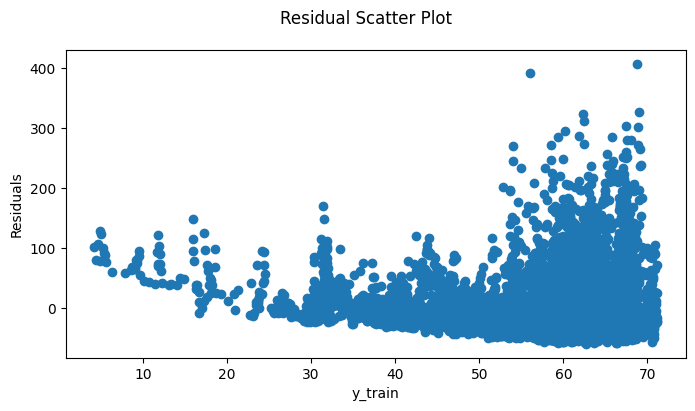

<AxesSubplot:xlabel='mean_wind_spd', ylabel='target'>

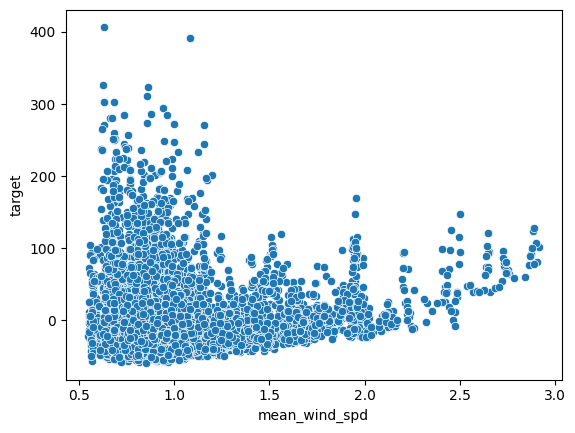

In [230]:
#calculate residuals
residuals=y_train-y_train_pred_base

# plot residuals
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(y_train_pred_base, residuals)
ax.set_ylabel("Residuals")
ax.set_xlabel("y_train")
fig.suptitle('Residual Scatter Plot')
plt.show()

sns.scatterplot(x=X_train['mean_wind_spd'], y=residuals)


### Milestone 1 - Baseline model

Value of Product:
* Predict air quality to protect people from hazardous conditions

Prediction:
* Air quality score (PM2.5 value)

Evaluation Metric:
* Root-Mean-Squared-Error (RMSE) (also recommended by Zindi)

Baseline Model:
* simple linear regression with the idea: higher wind speed = cleaner air

Score Baseline Model:
* RMSE = 44.1

## Modeling

### decision tree regression

In [231]:
# create a regressor object 
dec_tree = DecisionTreeRegressor(max_features=100, max_depth=20, criterion='squared_error')  
  
# fit the regressor with X and Y data 
dec_tree.fit(X_train, y_train) 

DecisionTreeRegressor(max_depth=20, max_features=100)

In [232]:
y_train_pred = dec_tree.predict(X_train)
y_test_pred = dec_tree.predict(X_test)

print('Train data: ', mean_squared_error(y_train,y_train_pred, squared=False),
      'Test data: ', mean_squared_error(y_test,y_test_pred, squared=False))


Train data:  6.164166935584411 Test data:  39.70316730839345


### Random forest regression

In [233]:
# Random forest regression
# create a regressor object 
ran_for = RandomForestRegressor(n_estimators=100, max_features=74, max_depth=20,n_jobs=-1, criterion='squared_error', random_state=RSEED)  
  
# fit the regressor with X and Y data 
ran_for.fit(X_train, y_train) 

RandomForestRegressor(max_depth=20, max_features=74, n_jobs=-1, random_state=42)

In [234]:
ran_for.feature_importances_.max()
X_train.columns[ran_for.feature_importances_.argmax()]



'location_C'

In [235]:
y_train_pred_rf = ran_for.predict(X_train)
y_test_pred_rf = ran_for.predict(X_test)

print('Train data: ', mean_squared_error(y_train,y_train_pred_rf, squared=False), 
        'Test data: ', mean_squared_error(y_test,y_test_pred_rf, squared=False))
print('Train data baseline: ', mean_squared_error(y_train,y_train_pred_base, squared=False), 
        'Test data baseline: ', mean_squared_error(y_test,y_test_pred_base, squared=False))

Train data:  10.334795839484425 Test data:  26.059225862780067
Train data baseline:  41.567708595103255 Test data baseline:  43.92745197153489


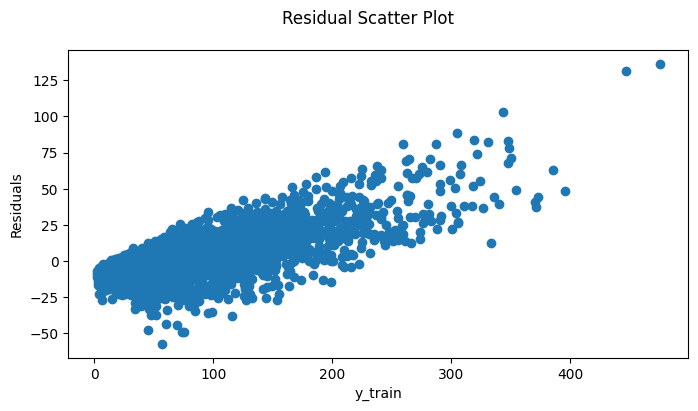

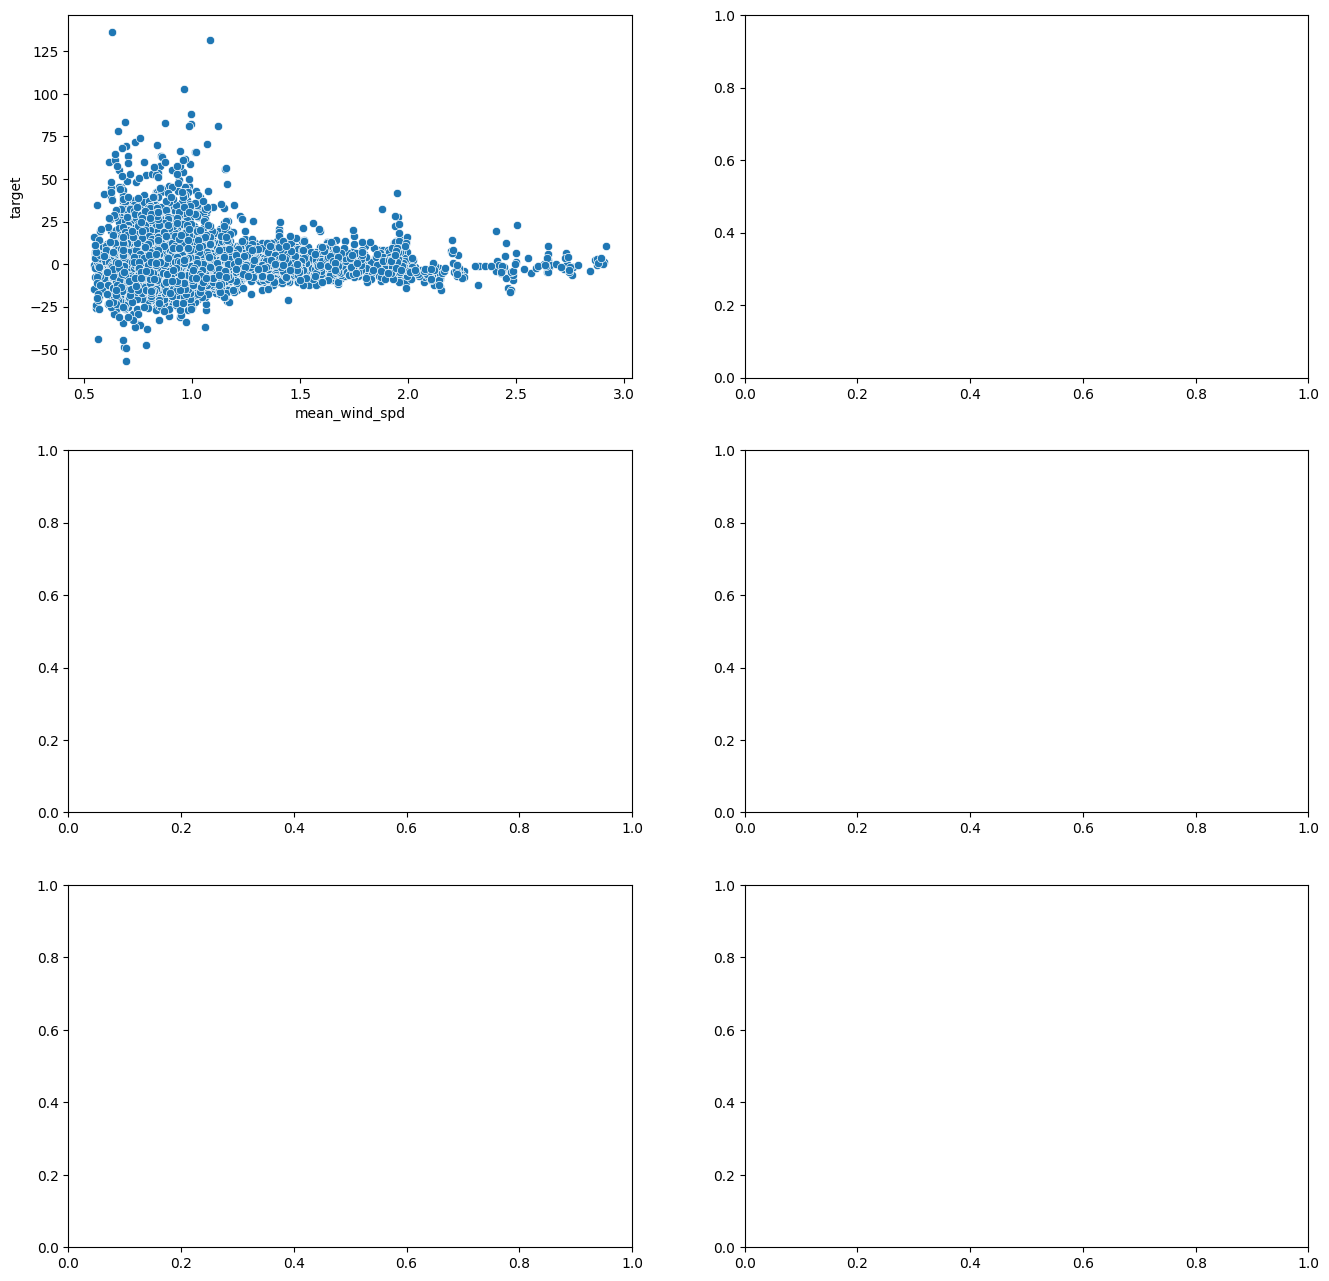

In [236]:
#calculate residuals
residuals=y_train-y_train_pred_rf

# plot residuals
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(y_train, residuals)
ax.set_ylabel("Residuals")
ax.set_xlabel("y_train")
fig.suptitle('Residual Scatter Plot')
plt.show()

fig,ax = plt.subplots(3,2,figsize=(16,16))
count=0
for feat in baseline_features:
    sns.scatterplot(x=X_train[feat], y=residuals, #hue=X_train.location,
                    ax=ax[int(count/2)][count%2])
    count += 1


## Other models

### Scaling

In [237]:
from sklearn.preprocessing import StandardScaler

# Columns with numerical values
col_scale = X_train.columns.drop(['location_B', 'location_C', 'location_D', 'location_E'])

# reset indices because some lines have been dropped while imputing
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Scaling with standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

# Change type to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_scale)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_scale)

In [238]:
# Concatenating scaled and dummy columns 
X_train = pd.concat([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test = pd.concat([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

In [239]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [240]:
def train_predict_evaluate(model, X_train, y_train, X_test, y_test):
    """Train model, make prediction and evaluate

    Args:
        model (_type_): Regressor model
        X_train (_type_): Train data features
        y_train (_type_): Train data target
        X_test (_type_): Test data features
        y_test (_type_): Test data target
    """
    # train model
    model.fit(X_train, y_train)

    # make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # print metrics of predictions
    print(f"Model: {type(model)}") 
    print(f"RMSE on train data: {mean_squared_error(y_train, y_train_pred, squared=False)}")
    print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred, squared=False)}")
    #print(f"R2 on train data: {r2_score(y_train, y_train_pred)}")
    #print(f"R2 on test data: {r2_score(y_test, y_test_pred)}")
    print('-----------------------------')


In [241]:
model_dectree_reg = DecisionTreeRegressor(max_features=100, max_depth=20, criterion='squared_error', random_state=RSEED)
model_adaboost    = AdaBoostRegressor(random_state=RSEED)
model_svr         = SVR()
model_sgdr        = SGDRegressor(random_state=RSEED)
model_rfr         = RandomForestRegressor(random_state=RSEED)
model_knr         = KNeighborsRegressor()
model_xgbr        = XGBRegressor()

models = [model_dectree_reg, model_adaboost, model_svr, model_sgdr, model_rfr, model_knr, model_xgbr]

for model in tqdm(models):
    train_predict_evaluate(model, X_train, y_train, X_test, y_test)

 14%|█▍        | 1/7 [00:00<00:05,  1.16it/s]

Model: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RMSE on train data: 7.5220075247332066
RMSE on test data: 38.108424673920375
-----------------------------


 29%|██▊       | 2/7 [00:16<00:47,  9.48s/it]

Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
RMSE on train data: 50.58304496330107
RMSE on test data: 51.33032215590466
-----------------------------


 43%|████▎     | 3/7 [01:03<01:46, 26.59s/it]

Model: <class 'sklearn.svm._classes.SVR'>
RMSE on train data: 37.87115978079006
RMSE on test data: 38.7630933698391
-----------------------------


 57%|█████▋    | 4/7 [01:03<00:48, 16.22s/it]

Model: <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>
RMSE on train data: 35.24968075330187
RMSE on test data: 38.3735970616304
-----------------------------


 71%|███████▏  | 5/7 [03:39<02:13, 66.55s/it]

Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.583496564067099
RMSE on test data: 25.973066723435533
-----------------------------


 86%|████████▌ | 6/7 [03:42<00:44, 44.92s/it]

Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 22.173421091273152
RMSE on test data: 29.855310519625732
-----------------------------


100%|██████████| 7/7 [03:47<00:00, 32.54s/it]

Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 8.967349006414217
RMSE on test data: 25.960156608941265
-----------------------------


### Blocksize 1 hour (120 remaining values):

```BASH
Model: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RMSE on train data: 7.209391028766635
RMSE on test data: 42.0904465672757
-----------------------------
 Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
RMSE on train data: 48.86331639264925
RMSE on test data: 50.36131410084777
-----------------------------
 Model: <class 'sklearn.svm._classes.SVR'>
RMSE on train data: 38.87860647400892
RMSE on test data: 39.944618201958974
-----------------------------
 Model: <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>
RMSE on train data: 34.19963821655823
RMSE on test data: 38.63442131277351
-----------------------------
 Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.9414417005997
RMSE on test data: 27.96724578110358
-----------------------------
 Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 25.83425249131009
RMSE on test data: 35.08664033755645
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 7.54119158473235
RMSE on test data: 28.942193934356123
-----------------------------
```

### after optimization with grid search:

```BASH
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 10.140614707830288
RMSE on test data: 27.95631190773678
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 0.0
RMSE on test data: 27.95860857823004
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 7.815084095159945
RMSE on test data: 26.785504149590594
-----------------------------
```

### Blocksize 4 hours (30 remaining values)

```BASH
Model: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RMSE on train data: 6.861824669777071
RMSE on test data: 38.98380064351548
-----------------------------
Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
RMSE on train data: 51.67530995157467
RMSE on test data: 53.47638990064306
-----------------------------
Model: <class 'sklearn.svm._classes.SVR'>
RMSE on train data: 38.244079215867544
RMSE on test data: 39.36455352002777
-----------------------------
Model: <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>
RMSE on train data: 34.136099705938825
RMSE on test data: 37.127521118776805
-----------------------------
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.433325256192974
RMSE on test data: 26.828452008742286
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 22.082161907530807
RMSE on test data: 30.9929499664167
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 7.9779823294635355
RMSE on test data: 27.626092371588882
-----------------------------
```

### after optimization with grid search:
```BASH
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.313748577612795
RMSE on test data: 26.541551406320476
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 0.0
RMSE on test data: 27.2110823712336
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 8.003318754248372
RMSE on test data: 26.096372611484604
-----------------------------
```

### Blocksize 6 hours (20 remaining values)

```BASH
Model: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RMSE on train data: 5.735740706660298
RMSE on test data: 40.1882422138978
-----------------------------
Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
RMSE on train data: 41.66941445457626
RMSE on test data: 43.49884874233341
-----------------------------
Model: <class 'sklearn.svm._classes.SVR'>
RMSE on train data: 38.1956640340048
RMSE on test data: 39.358971702501115
-----------------------------
Model: <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>
RMSE on train data: 34.22582490576281
RMSE on test data: 37.671397379559885
-----------------------------
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.204402901872767
RMSE on test data: 26.74148866975374
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 21.643230966742323
RMSE on test data: 31.099745049831792
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 8.667607097383996
RMSE on test data: 29.17977074581071
-----------------------------
```

### after optimization with grid search:
```BASH
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.113701766689154
RMSE on test data: 26.125783645361363
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 0.0
RMSE on test data: 27.99505328850496
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 8.366444635888584
RMSE on test data: 26.152130619281284
-----------------------------
```

### Blocksize 8 hours (15 values remaining)

```BASH
Model: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RMSE on train data: 7.028851852593023
RMSE on test data: 39.73926807463883
-----------------------------
Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
RMSE on train data: 56.68661025659285
RMSE on test data: 58.07873438929974
-----------------------------
Model: <class 'sklearn.svm._classes.SVR'>
RMSE on train data: 38.36405170632363
RMSE on test data: 39.68258321553612
-----------------------------
Model: <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>
RMSE on train data: 34.171676750174846
RMSE on test data: 37.60128341481845
-----------------------------
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.116418860486675
RMSE on test data: 27.517542310758618
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 22.35473652734791
RMSE on test data: 32.3394777230019
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 9.352866486726729
RMSE on test data: 29.134298103939315
```
### after grid search:
```BASH
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.075198998450773
RMSE on test data: 26.46789409192106
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 0.0
RMSE on test data: 28.628930312055612
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 8.928383328639605
RMSE on test data: 26.697076909978104
-----------------------------
```

### Blocksize 10 hours (12 values remaining)

```BASH
 Model: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RMSE on train data: 8.095220789148255
RMSE on test data: 43.57607296695165
-----------------------------
 Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
RMSE on train data: 50.51125911461714
RMSE on test data: 51.56593078303908
-----------------------------
 Model: <class 'sklearn.svm._classes.SVR'>
RMSE on train data: 38.230457067736616
RMSE on test data: 39.50722757944204
-----------------------------
Model: <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>
RMSE on train data: 35.64132545788088
RMSE on test data: 39.50260436888725
-----------------------------
 Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.119784162538997
RMSE on test data: 27.691737374891883
-----------------------------
 Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 22.57204339195656
RMSE on test data: 32.106182417864304
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 9.197958398656853
RMSE on test data: 29.41196674584678
-----------------------------
```

### after grid search:
```BASH
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.049730258154485
RMSE on test data: 26.71390611853816
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 0.0
RMSE on test data: 28.751676051231605
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 9.387880028391226
RMSE on test data: 26.70179750916552
-----------------------------
```

### Blocksize 12 hours (10 values remaining)
```BASH
Model: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RMSE on train data: 8.095220789148255
RMSE on test data: 43.57607296695165
-----------------------------
Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
RMSE on train data: 50.51125911461714
RMSE on test data: 51.56593078303908
-----------------------------
Model: <class 'sklearn.svm._classes.SVR'>
RMSE on train data: 38.230457067736616
RMSE on test data: 39.50722757944204
-----------------------------
Model: <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>
RMSE on train data: 35.64132545788088
RMSE on test data: 39.50260436888725
-----------------------------
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.119784162538997
RMSE on test data: 27.691737374891883
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 22.57204339195656
RMSE on test data: 32.106182417864304
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 9.197958398656853
RMSE on test data: 29.41196674584678
-----------------------------
```

### after grid search:
```BASH
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.049730258154485
RMSE on test data: 26.71390611853816
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 0.0
RMSE on test data: 28.751676051231605
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 9.387880028391226
RMSE on test data: 26.70179750916552
-----------------------------
```

### Blocksize 24 hours (5 values remaining)

```BASH
Model: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
RMSE on train data: 8.038327467307695
RMSE on test data: 41.41089603168517
-----------------------------
Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
RMSE on train data: 44.342324428782256
RMSE on test data: 46.545371965186746
-----------------------------
Model: <class 'sklearn.svm._classes.SVR'>
RMSE on train data: 39.936771124634205
RMSE on test data: 41.218241864145796
-----------------------------
Model: <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>
RMSE on train data: 37.67035118611836
RMSE on test data: 39.6293122431521
-----------------------------
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.828940972734195
RMSE on test data: 32.35342148721305
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 23.540739053860047
RMSE on test data: 35.326704462646276
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 14.604548060387405
RMSE on test data: 43.22880978636078
-----------------------------
```

### after grid search
```BASH
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.743208886783743
RMSE on test data: 31.105879078174492
-----------------------------
Model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
RMSE on train data: 0.0
RMSE on test data: 30.369909440207294
-----------------------------
Model: <class 'xgboost.sklearn.XGBRegressor'>
RMSE on train data: 7.969003272728944
RMSE on test data: 41.61266053945332
-----------------------------
```

### Choose model and find good hyperparameters

In [243]:
from sklearn.model_selection import GridSearchCV

In [244]:
def grid_search_evaluate(model, hyperparameters, X_train, y_train, X_test, y_test):
    """make grid search for model parameters, get the best estimator, make prediction and evaluate

    Args:
        model (_type_): Regressor model
        hyperparameters (_type_): parameter list for the grid search
        X_train (_type_): Train data features
        y_train (_type_): Train data target
        X_test (_type_): Test data features
        y_test (_type_): Test data target
    """
    
    gs = GridSearchCV(model, hyperparameters, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=3, verbose = 2)

    # Fit the grid search object to the training data and find the optimal parameters
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_

    # make predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # print metrics of predictions
    print(f"Model: {type(best_model)}") 
    print(f"RMSE on train data: {mean_squared_error(y_train, y_train_pred, squared=False)}")
    print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred, squared=False)}")
    #print(f"R2 on train data: {r2_score(y_train, y_train_pred)}")
    #print(f"R2 on test data: {r2_score(y_test, y_test_pred)}")
    print('-----------------------------')

    return best_model

In [246]:
model_rfr = RandomForestRegressor(random_state=RSEED)
model_knr = KNeighborsRegressor()
model_xgbr = XGBRegressor()

models = [model_rfr, model_knr, model_xgbr]


# Create the parameters list you wish to tune
parameters_rfr = {
                #'n_estimators':[95, 100, 105],                
                'max_features':[55, 60, 65],               
                #'max_depth' : [35, 100], 
                #'min_samples_split': [2,4,6]
                } 
parameters_knr = {
                'n_neighbors':[5, 10],                
                'metric':['euclidean', 'manhattan'],               
                'weights':['uniform', 'distance'],                         
                } 
parameters_xgbr = {
                'eta': [0.1, 0.3, 0.5],
                'max_depth': [4, 6, 8],
                'eval_metric': ['rmse']
                }

params = [parameters_rfr, parameters_knr, parameters_xgbr]

# best_models = []
# for model, param in tqdm(zip(models, params)):
#     best_models.append(grid_search_evaluate(model, param, X_train, y_train, X_test, y_test))



In [247]:
best_rfr = grid_search_evaluate(model_rfr, parameters_rfr, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ....................................max_features=55; total time=  30.2s
[CV] END ....................................max_features=55; total time=  30.4s
[CV] END ....................................max_features=55; total time=  31.5s
[CV] END ....................................max_features=60; total time=  32.9s
[CV] END ....................................max_features=60; total time=  33.2s
[CV] END ....................................max_features=60; total time=  33.4s
[CV] END ....................................max_features=65; total time=  34.5s
[CV] END ....................................max_features=65; total time=  35.4s
[CV] END ....................................max_features=65; total time=  24.3s
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
RMSE on train data: 9.574738636693587
RMSE on test data: 25.804804841441324
-----------------------------


In [250]:
best_rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 55,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [251]:
best_knr = grid_search_evaluate(model_knr, parameters_knr, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   3.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   3.1s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   3.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   3.0s
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=   2.9s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   3.2s
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=   3.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   3.2s
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=   1.2s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   1.1s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   1.2s
[CV] END .metric=euclidean, n_neighbors=10, weigh

In [252]:
best_knr.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'distance'}

In [253]:
best_xgbr = grid_search_evaluate(model_xgbr, parameters_xgbr, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .............eta=0.1, eval_metric=rmse, max_depth=4; total time=  18.3s
[CV] END .............eta=0.1, eval_metric=rmse, max_depth=4; total time=  18.6s
[CV] END .............eta=0.1, eval_metric=rmse, max_depth=4; total time=  18.7s
[CV] END .............eta=0.1, eval_metric=rmse, max_depth=6; total time=  28.3s
[CV] END .............eta=0.1, eval_metric=rmse, max_depth=6; total time=  28.6s
[CV] END .............eta=0.1, eval_metric=rmse, max_depth=6; total time=  29.0s
[CV] END .............eta=0.3, eval_metric=rmse, max_depth=4; total time=  19.2s
[CV] END .............eta=0.3, eval_metric=rmse, max_depth=4; total time=  19.6s
[CV] END .............eta=0.1, eval_metric=rmse, max_depth=8; total time=  38.6s
[CV] END .............eta=0.1, eval_metric=rmse, max_depth=8; total time=  38.9s
[CV] END .............eta=0.3, eval_metric=rmse, max_depth=4; total time=  20.7s
[CV] END .............eta=0.3, eval_metric=rmse, 

In [254]:
best_xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'rmse',
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.100000001,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 8,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eta': 0.1}

### Model evaluation

In [255]:
y_train_pred_best = best_rfr.predict(X_train)
y_test_pred_best = best_rfr.predict(X_test)

In [256]:
# evaluate air quality hazard levels from pm2.5 values
y_train_levels = pd.Series(y_train).apply(aqf.hazard_level)
y_test_levels = pd.Series(y_test).apply(aqf.hazard_level)

y_train_pred_best_levels = pd.Series(y_train_pred_best).apply(aqf.hazard_level)
y_test_pred_best_levels = pd.Series(y_test_pred_best).apply(aqf.hazard_level)

[[   0   44   12    1    0    0]
 [   0  444  456   93    0    0]
 [   0   42  806  518    0    0]
 [   0    3  196 1098   14    0]
 [   0    0    0   85   42    0]
 [   0    0    0    8   21    2]]
0.6157014157014157
0.600992253992213


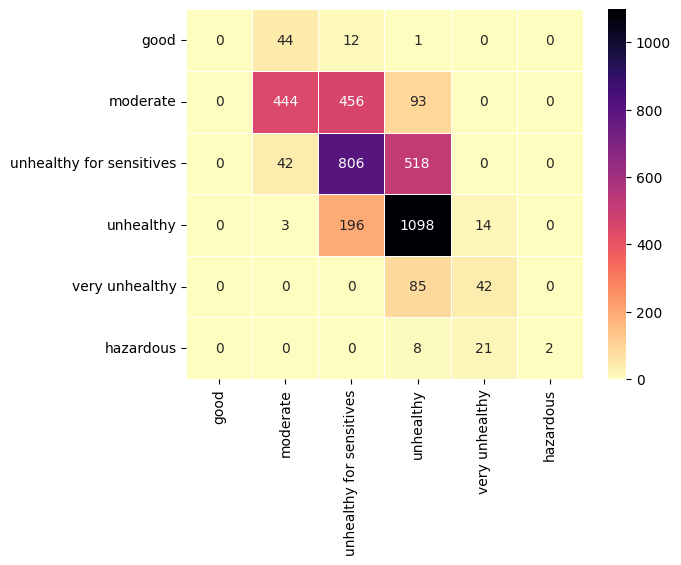

In [257]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

hazard_labels = ['good', 'moderate', 'unhealthy for sensitives', 'unhealthy', 'very unhealthy', 'hazardous']

cm = confusion_matrix(y_test_levels, y_test_pred_best_levels, labels=hazard_labels)
print(cm)
print(accuracy_score(y_test_levels, y_test_pred_best_levels))
print(f1_score(y_test_levels, y_test_pred_best_levels, average='weighted'))


sns.heatmap(cm, cmap='magma_r', annot=True, fmt='d', linewidths=.5, xticklabels=hazard_labels, yticklabels=hazard_labels);

## Ideas for feature engineering

* replace location columns with other information (e.g. num of households with charcoal fireplaces)
* add differences from one 6-hour block to the next as new columns &rarr; trend might be an important feature for the model
* correct atmospheric pressure by the altitude of the sensor (sensor altitude is like a constant offset)

### Stacking

In [266]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('rfr', RandomForestRegressor(max_features=55, random_state = RSEED)),
    ('knr', KNeighborsRegressor(n_neighbors=5, metric="manhattan", )),
    ('xgbr', XGBRegressor())
]

model_stack = StackingRegressor(estimators = estimators, final_estimator = LinearRegression(), cv=3, n_jobs=-1)
model_stack.fit(X_train, y_train).score(X_test, y_test)

y_train_pred_stack = model_stack.predict(X_train)
y_test_pred_stack = model_stack.predict(X_test)

print(f"RMSE on train data: {mean_squared_error(y_train, y_train_pred_stack, squared=False)}")
print(f"RMSE on test data: {mean_squared_error(y_test, y_test_pred_stack, squared=False)}")

RMSE on train data: 8.216403840817227
RMSE on test data: 24.484337070388865


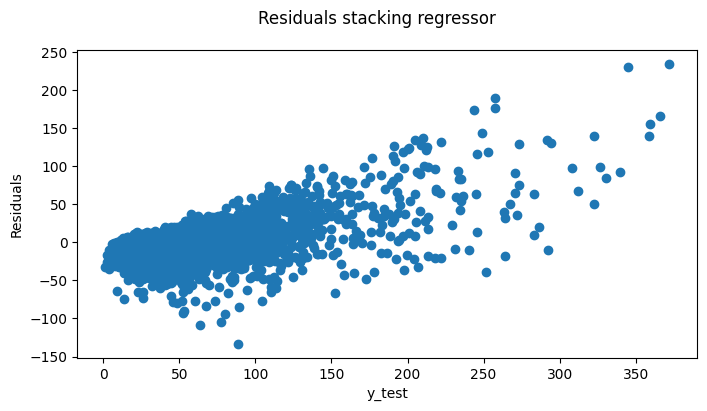

In [267]:
#calculate residuals
residuals = y_test - y_test_pred_stack

# plot residuals
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(y_test, residuals)
ax.set_ylabel("Residuals")
ax.set_xlabel("y_test")
fig.suptitle('Residuals stacking regressor')
plt.show()

In [268]:
y_train_pred_stack_levels = pd.Series(y_train_pred_stack).apply(aqf.hazard_level)
y_test_pred_stack_levels = pd.Series(y_test_pred_stack).apply(aqf.hazard_level)

[[  15   35    6    1    0    0]
 [  20  580  317   76    0    0]
 [   0  162  754  450    0    0]
 [   0   15  220 1050   26    0]
 [   0    0    0   68   58    1]
 [   0    0    0    6   19    6]]
0.633976833976834
0.6282495418695677


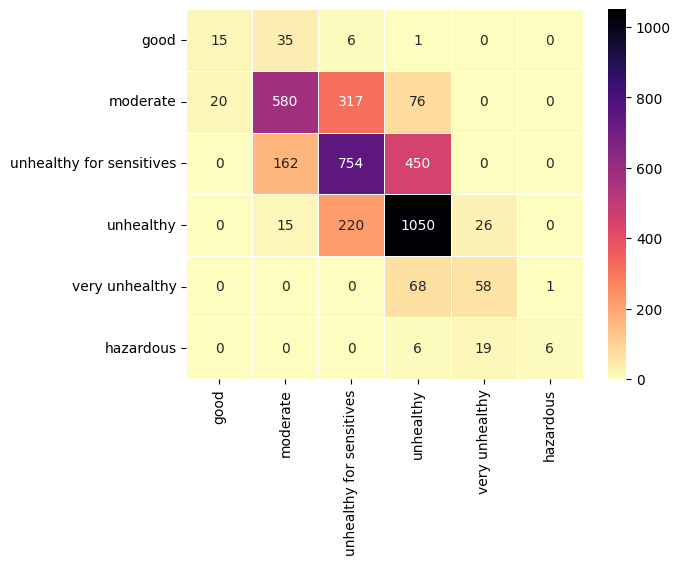

In [269]:
cm = confusion_matrix(y_test_levels, y_test_pred_stack_levels, labels=hazard_labels)
print(cm)
print(accuracy_score(y_test_levels, y_test_pred_stack_levels))
print(f1_score(y_test_levels, y_test_pred_stack_levels, average='weighted'))


sns.heatmap(cm, cmap='magma_r', annot=True, fmt='d', linewidths=.5, xticklabels=hazard_labels, yticklabels=hazard_labels);